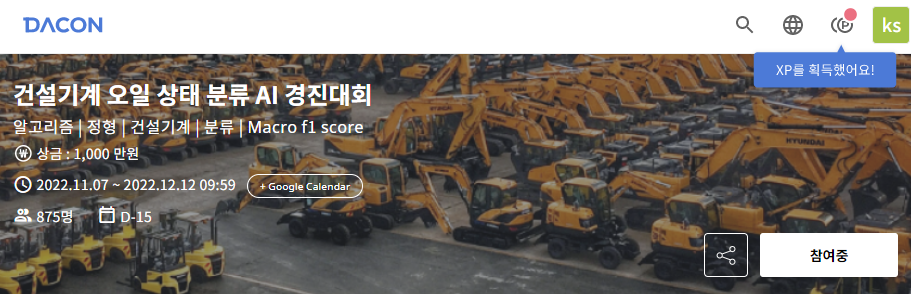

In [2053]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2054]:
file_version = 53
CFG = {
    'EPOCHS': 30,
    'LEARNING_RATE':1e-2,    # 0.01
    'BATCH_SIZE':256,  #256
    'SEED':43,
    'log_transform_turn': 1,  # 로그 트랜스폼을 몇번 돌릴 것인가?
    'skew_cut':0.01,           # 왜도 얼마 이상을 로그값으로 정규화할 것인가?(100이면 안하겠다는 것)
    'vif_cut': 10,           # 다중공선성 vif 얼마 이상을 제거할 것인가?
    'corr_cut': 0.004,     # 일정 상관관계 이하 칼럼은 드랍
    'outlier_corr_cut': 100,    # 이값 이상의 상관관계를 갖는 칼럼에 대해서만 아웃라이어 제거(100이면 미적용)
    'T_Thresh': 0.3,     # Teacher model train Threshhold 최초 0.35
    'S_Thresh': 0.325,     # Student model train Threshold 최초 0.35
    'reduct' : 'sum',      # sum, mean
    'drop_rate': 0.2,
    
}

In [2055]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

# 1. EDA

- 결측치 처리
- 왜도 정규화 처리
- 스케일링
- 다중공선성 검토

In [2056]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [2057]:
train["Y_LABEL"].value_counts()

0    12892
1     1203
Name: Y_LABEL, dtype: int64

In [2058]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14095 non-null  object 
 1   COMPONENT_ARBITRARY  14095 non-null  object 
 2   ANONYMOUS_1          14095 non-null  int64  
 3   YEAR                 14095 non-null  int64  
 4   SAMPLE_TRANSFER_DAY  14095 non-null  int64  
 5   ANONYMOUS_2          14095 non-null  int64  
 6   AG                   14095 non-null  int64  
 7   AL                   14095 non-null  int64  
 8   B                    14095 non-null  int64  
 9   BA                   14095 non-null  int64  
 10  BE                   14095 non-null  int64  
 11  CA                   14095 non-null  int64  
 12  CD                   12701 non-null  float64
 13  CO                   14095 non-null  int64  
 14  CR                   14095 non-null  int64  
 15  CU                   14095 non-null 

In [2059]:
# test.info()

## (1) 결측치

In [2060]:
# 데이터를 콤포넌트별로 쪼개기

In [2061]:
train["COMPONENT_ARBITRARY"].value_counts().index

Index(['COMPONENT3', 'COMPONENT1', 'COMPONENT2', 'COMPONENT4'], dtype='object')

In [2062]:
train[train["COMPONENT_ARBITRARY"] == "COMPONENT3"]

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,154.0,75,0
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.1,128,0
5,TRAIN_00005,COMPONENT3,2061,2008,4,550,0,3,8,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,69.7,1015,0
6,TRAIN_00006,COMPONENT3,1416,2015,7,616,0,0,21,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,148.5,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14082,TRAIN_14082,COMPONENT3,3060,2010,2,200,0,2,3,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,140.0,35,1
14086,TRAIN_14086,COMPONENT3,1637,2008,16,487,0,11,99,2,...,NaN,NaN,NaN,NaN,NaN,0,NaN,152.6,21,1
14088,TRAIN_14088,COMPONENT3,1311,2010,6,511,0,0,20,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,128.9,20,0
14090,TRAIN_14090,COMPONENT3,1616,2014,8,200,0,2,201,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,135.4,16,0


In [2063]:
train_c1 = train[train["COMPONENT_ARBITRARY"] == "COMPONENT1"]
train_c2 = train[train["COMPONENT_ARBITRARY"] == "COMPONENT2"]
train_c3 = train[train["COMPONENT_ARBITRARY"] == "COMPONENT3"]
train_c4 = train[train["COMPONENT_ARBITRARY"] == "COMPONENT4"]

In [2064]:
train_list = [train_c1, train_c2, train_c3, train_c4]

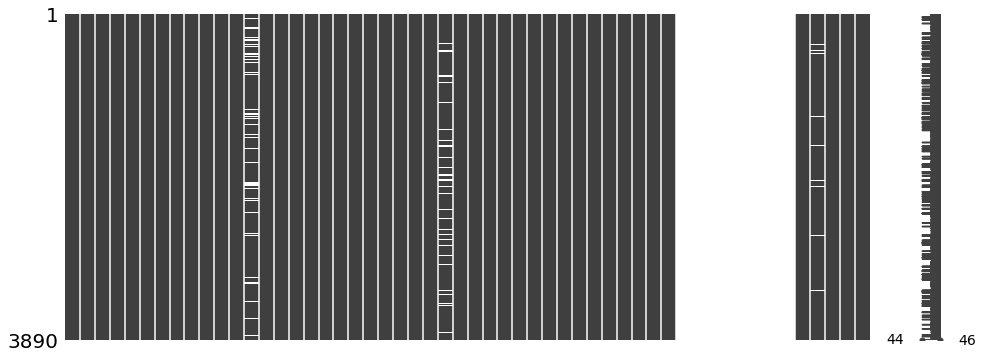

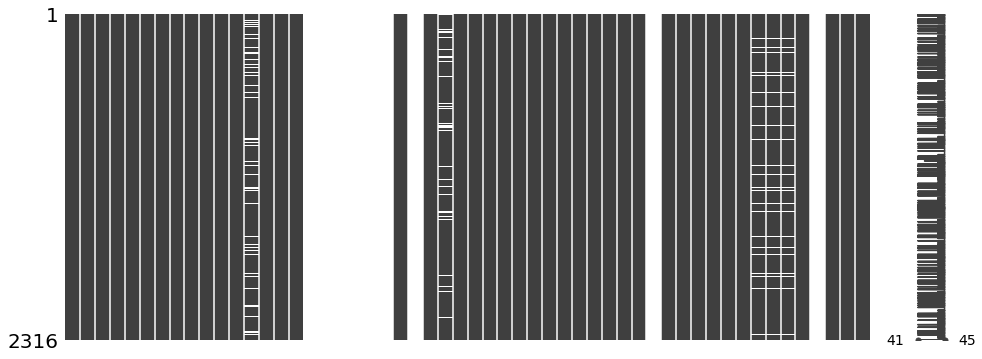

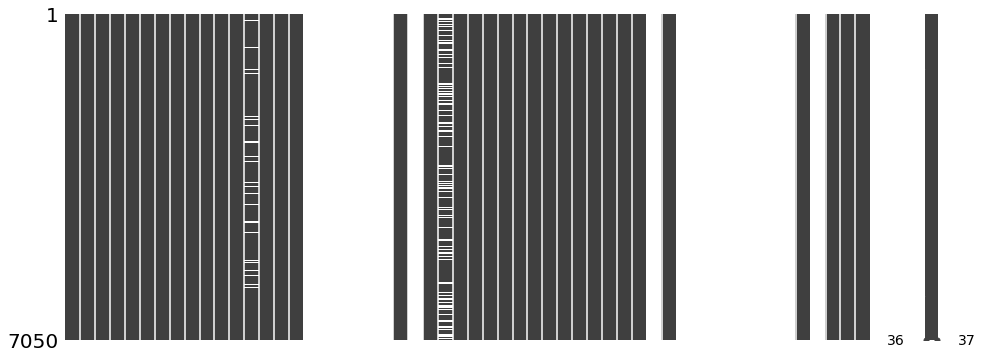

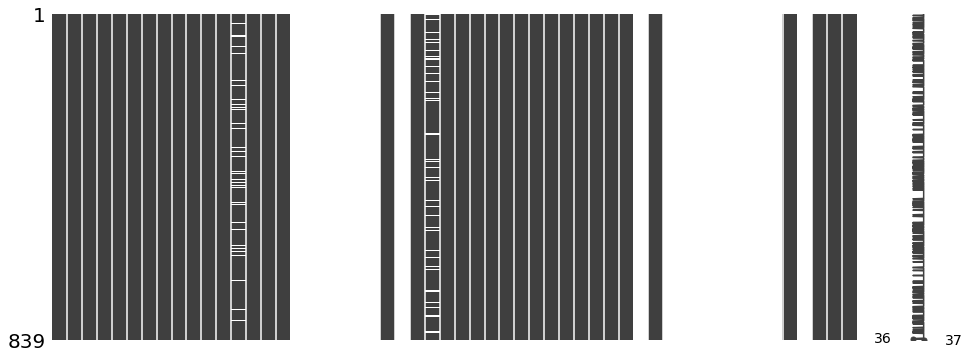

In [2065]:
import missingno as msno
for i in train_list:
    msno.matrix(i, figsize=(16,6))

In [2066]:
# def 보간값(col):
#     평균 = train[col].mean()
#     중위수 = train[col].median()
#     최빈값 = train[col].mode().values[0]
#     return {"평균": 평균, "중위수": 중위수, "최빈값":최빈값}

In [2067]:
for i in train_list:
    for col in i.columns.tolist():
        if i[col].isna().any():
#             최빈값 = i.groupby(["YEAR"])[[col]].agg(pd.Series.mode)
#             print(최빈값  
                       
            i[col].fillna(i.groupby(["YEAR"])[col].transform("median"),inplace=True)
        else:
            pass

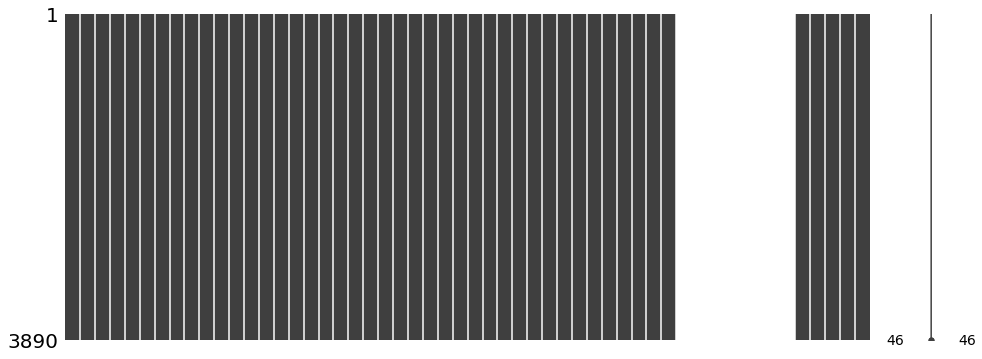

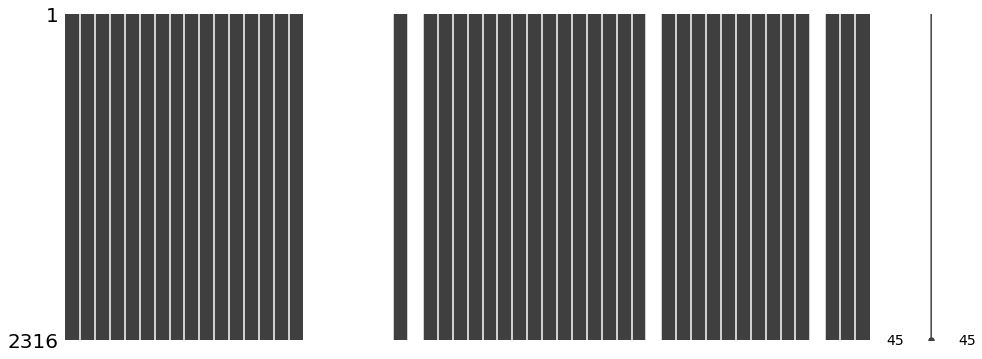

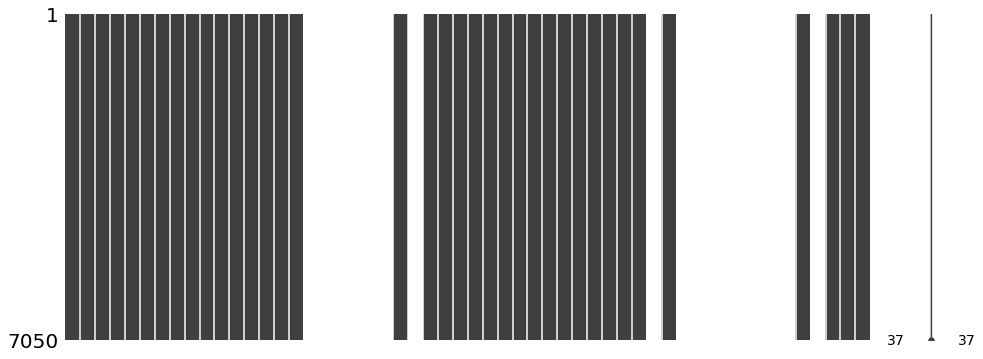

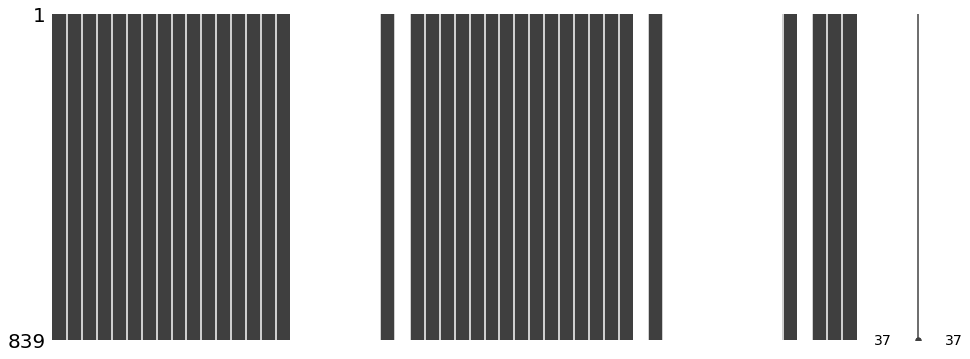

In [2068]:
for i in train_list:
    msno.matrix(i, figsize=(16,6))

In [2069]:
for i in train_list:
    null_cols = []
    for col in i.columns.tolist():
        if i[col].isna().any():
            null_cols.append(col)
        else:
            pass
    print(f"{null_cols}")
    i.drop(columns = null_cols, axis = 1, inplace = True)
    

['U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4']
['FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4', 'FTBN', 'FUEL', 'SOOTPERCENTAGE', 'V100']
['FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4', 'FTBN', 'FUEL', 'SOOTPERCENTAGE', 'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V100']
['FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4', 'FTBN', 'FUEL', 'SOOTPERCENTAGE', 'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V100']


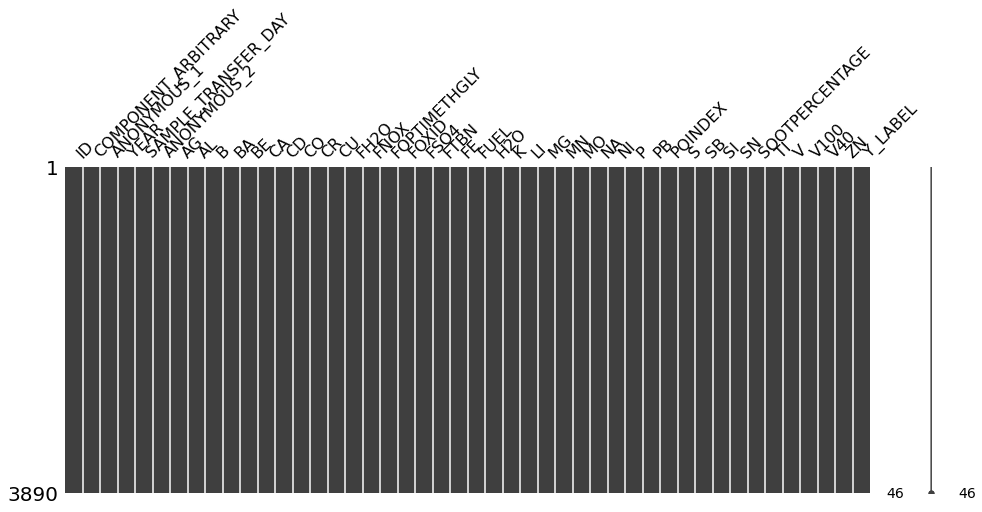

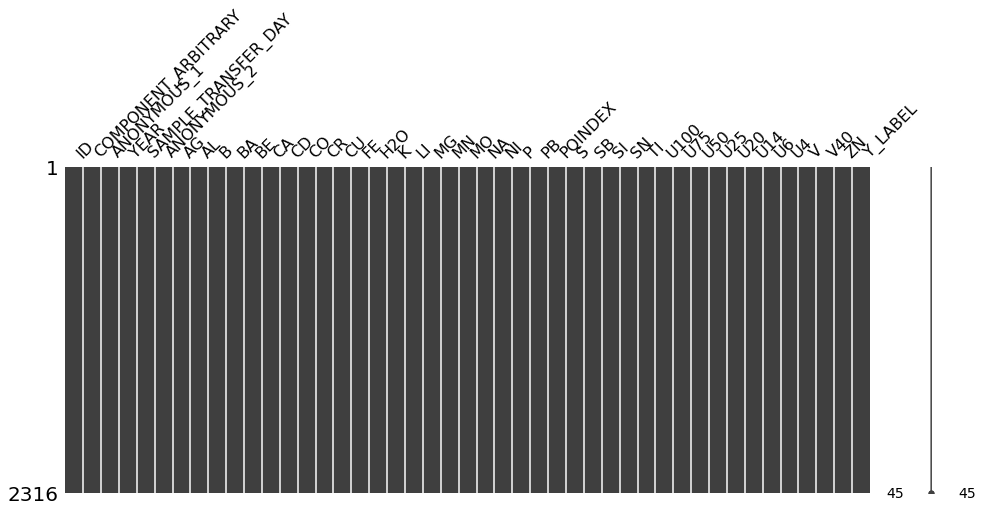

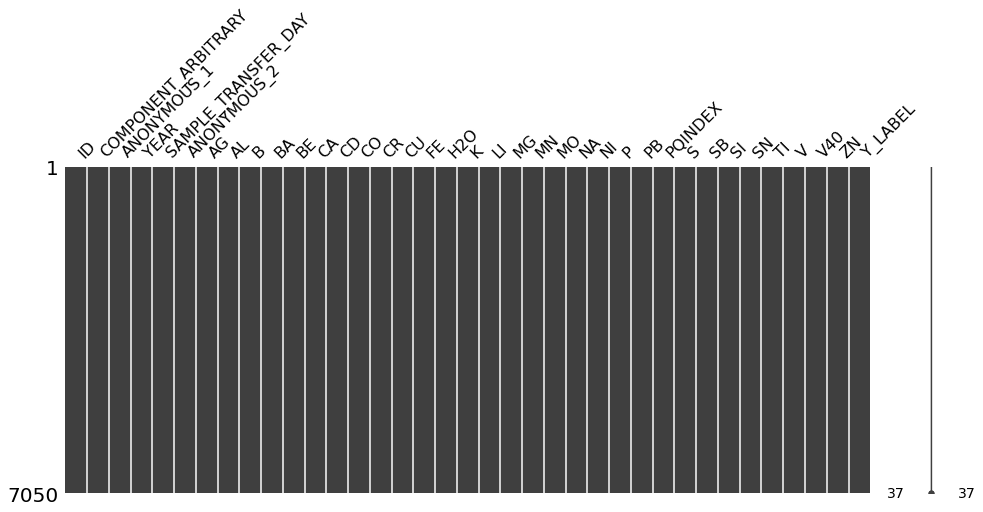

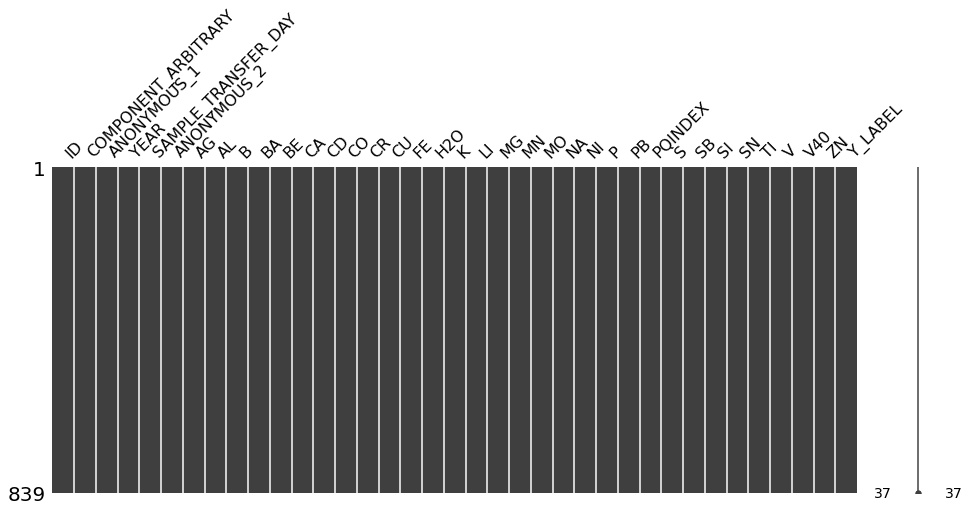

In [2070]:
for i in train_list:
    msno.matrix(i, figsize=(16,6))

In [2071]:
# test.head(15)

In [2072]:
test["order"] = [i for i in range(test.shape[0])]

In [2073]:
test_c1 = test[test["COMPONENT_ARBITRARY"] == "COMPONENT1"]
test_c2 = test[test["COMPONENT_ARBITRARY"] == "COMPONENT2"]
test_c3 = test[test["COMPONENT_ARBITRARY"] == "COMPONENT3"]
test_c4 = test[test["COMPONENT_ARBITRARY"] == "COMPONENT4"]
test_list = [test_c1, test_c2, test_c3, test_c4]

In [2074]:
test_c1.head(10)

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,order
0,TEST_0000,COMPONENT1,2192,2016,200,0,0,0,1,12,0.0,0,0,0,10,0,0,91.3,1091,0
11,TEST_0011,COMPONENT1,2033,2016,200,0,0,2,4,27,0.0,0,174,0,15,0,0,127.1,1188,11
12,TEST_0012,COMPONENT1,2369,2013,200,0,0,1,2,14,0.0,0,41,0,40,0,0,118.0,994,12
18,TEST_0018,COMPONENT1,2415,2021,565,0,0,1,2,34,0.0,0,0,0,5,0,0,87.8,1078,18
20,TEST_0020,COMPONENT1,2032,2013,200,0,0,5,15,62,0.0,0,147,0,11,0,0,111.2,1161,20
24,TEST_0024,COMPONENT1,2106,2008,200,0,0,2,5,17,0.0,1,1,0,55,0,1,96.9,1187,24
30,TEST_0030,COMPONENT1,1713,2013,913,0,0,0,0,8,0.0,0,202,0,2,0,0,101.1,1148,30
33,TEST_0033,COMPONENT1,2950,2014,200,0,0,6,3,54,0.0,1,53,0,23,0,0,118.1,1065,33
36,TEST_0036,COMPONENT1,1352,2007,550,0,0,5,48,51,0.0,2,14,1,31,1,0,90.1,1185,36
37,TEST_0037,COMPONENT1,4512,2016,200,0,0,0,1,16,0.0,1,42,0,19,0,0,105.2,1149,37


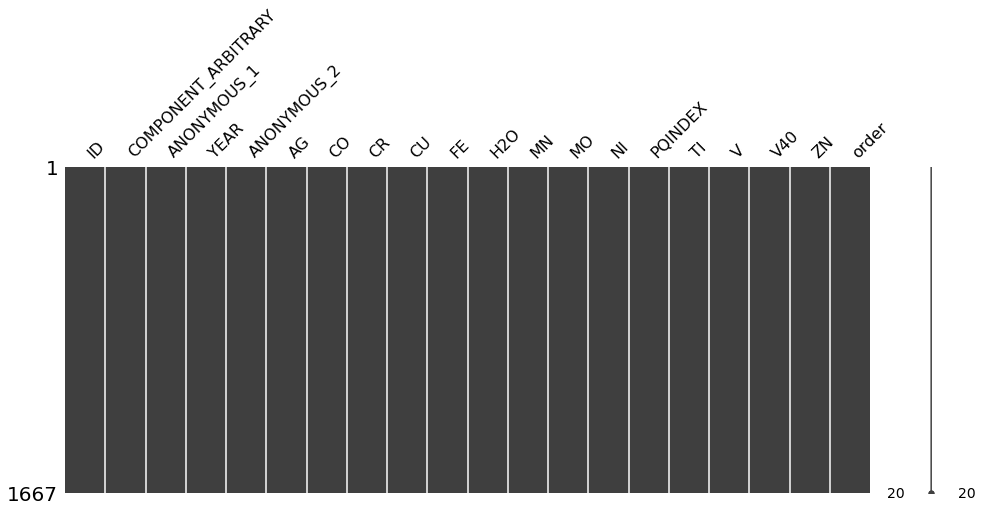

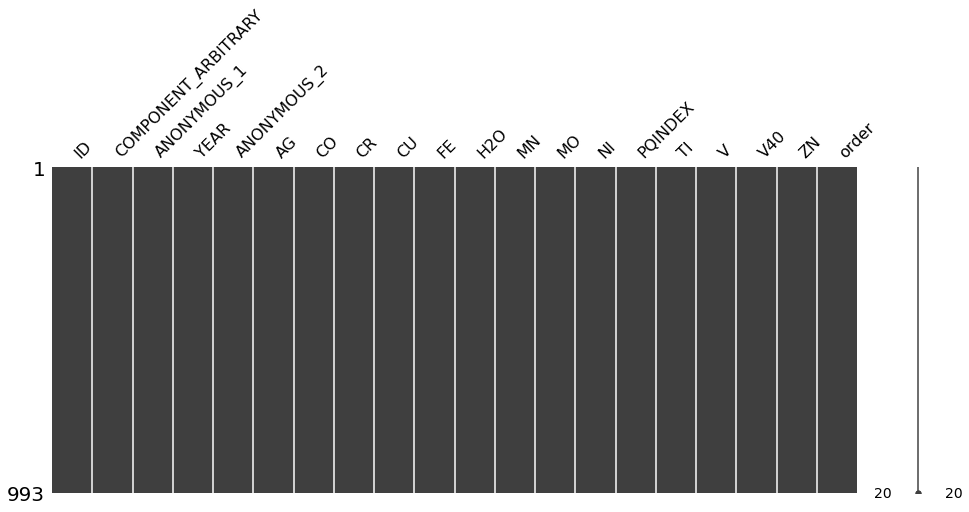

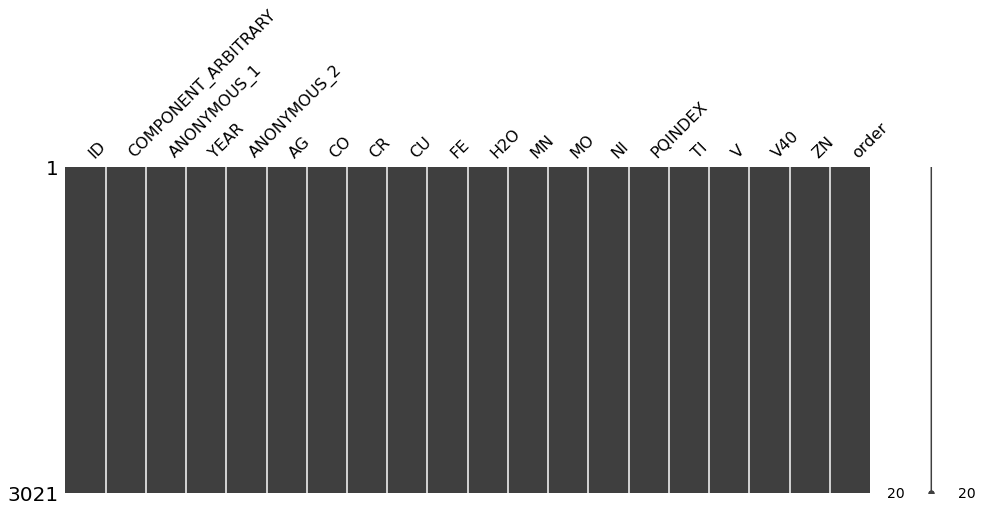

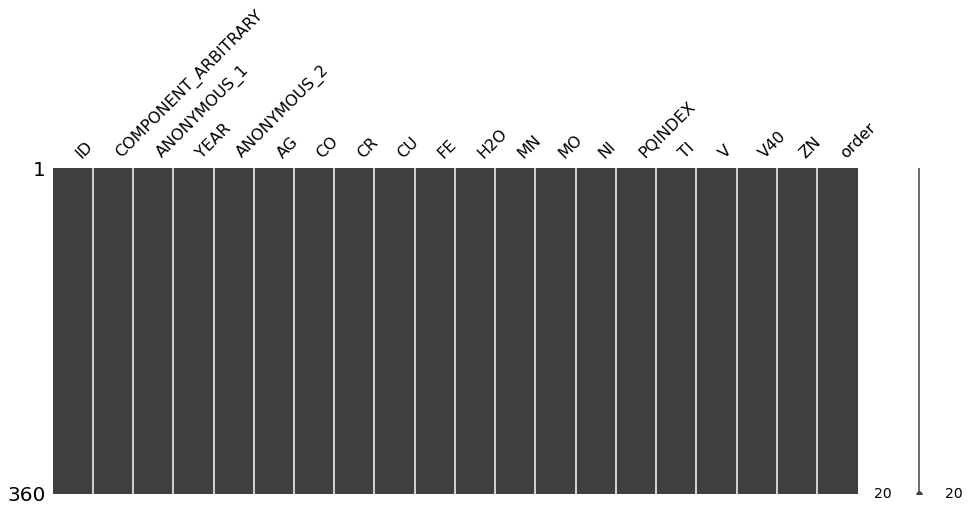

In [2075]:
for i in test_list:
    msno.matrix(i, figsize=(16,6))

## (2) 왜도 검토 - `Log Transform`

In [2076]:
# not_number_features = ['ID','COMPONENT_ARBITRARY', 'YEAR', "Y_LABEL"]
not_number_features = ['ID','COMPONENT_ARBITRARY', 'SAMPLE_TRANSFER_DAY','YEAR', "Y_LABEL", "order"]
for i in train_list:
    numerical_cols = list(set(i.columns.tolist())-set(not_number_features))
    print(len(numerical_cols))
    skewness = train[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
    print(skewness)
    print("="*50)


41
CR                54.368366
CD                53.085134
CO                49.810892
H2O               48.656666
NA                43.060333
BE                40.923712
SN                39.878475
PB                39.602904
MN                38.915313
BA                34.836012
TI                34.500761
ANONYMOUS_1       30.451948
LI                28.675390
K                 28.545327
SB                25.174375
AL                22.037843
V                 20.985827
CU                20.741422
NI                20.387033
FE                20.119119
SI                13.847020
V40               12.987017
FH2O              12.364062
PQINDEX            9.829113
ANONYMOUS_2        8.529989
FUEL               7.702714
AG                 7.309733
MG                 6.095664
FOPTIMETHGLY       3.680244
SOOTPERCENTAGE     3.124869
MO                 2.904525
B                  2.847296
FSO4               2.801530
FNOX               2.789648
FOXID              2.615895
P                

In [2077]:
#박스 플롯
def box_plot(df):
    세로열 = 3
    가로열 = int(len(numerical_cols)/세로열+1)

    fig, axes = plt.subplots(가로열, 3, figsize=(18, 30))
    a = 0
    for i, col in enumerate(numerical_cols):
            b=i%3
            sns.boxplot(ax=axes[a, b], data=df, x='Y_LABEL', y=col)
            if b == 2:
                a += 1

In [2078]:
# box_plot(train)

In [2079]:
def skew_chart(df):
    세로열 = 3
    가로열 = int(len(df.columns)/세로열+1)

    fig, axes = plt.subplots(가로열, 3, figsize=(20, 30))
    a = 0
    for i, col in enumerate(skew_feats):
        b=i%3
        sns.distplot(df[col], bins=100, ax=axes[a, b])
        plt.gca().set_title(col)
        plt.subplots_adjust(hspace = 0.8)
        if b == 2:
            a += 1

In [2080]:
# skew_chart(train)

In [2081]:
not_number_features = ['ID','COMPONENT_ARBITRARY', 'SAMPLE_TRANSFER_DAY','YEAR', "Y_LABEL", "order"]

for i in tqdm(train_list):
    numerical_cols = list(set(i.columns.tolist())-set(not_number_features))
    
    for turn in range(CFG["log_transform_turn"]):
        skewness = i[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
        skew_feats = skewness[skewness > CFG["skew_cut"]].index

        log_train = i[skew_feats].copy()
        log_train[skew_feats] = np.log1p(log_train[skew_feats])

        for col in skew_feats:
            i[col] = log_train[col]

        skewness = i[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
        print(skewness)
        print("="*50)



  0%|          | 0/4 [00:00<?, ?it/s]

H2O               33.630760
BE                19.548009
CO                13.382168
CD                13.013929
LI                 8.386079
TI                 8.171169
AG                 6.736011
V                  6.331146
FUEL               4.382078
NI                 4.061019
FH2O               3.912602
BA                 2.171357
ANONYMOUS_2        1.975926
SB                 1.862087
AL                 1.624135
MG                 1.425362
MN                 1.218008
SOOTPERCENTAGE     1.201435
PQINDEX            0.974142
FSO4               0.917912
CR                 0.893757
SN                 0.846870
ANONYMOUS_1        0.822632
CU                 0.785838
NA                 0.737381
FNOX               0.592093
SI                 0.546021
S                  0.471701
PB                 0.443891
FE                 0.328428
FOPTIMETHGLY       0.277592
FOXID              0.277294
K                  0.218440
B                  0.166743
MO                -0.062199
P                 -0

In [2082]:
not_number_features = ['ID','COMPONENT_ARBITRARY', 'SAMPLE_TRANSFER_DAY','YEAR', "Y_LABEL", "order"]

for i in tqdm(test_list):
    numerical_cols = list(set(i.columns.tolist())-set(not_number_features))
    
    for turn in range(CFG["log_transform_turn"]):
        skewness = i[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
        skew_feats = skewness[skewness > CFG["skew_cut"]].index

        log_train = i[skew_feats].copy()
        log_train[skew_feats] = np.log1p(log_train[skew_feats])

        for col in skew_feats:
            i[col] = log_train[col]

        skewness = i[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
        print(skewness)
        print("="*50)


  0%|          | 0/4 [00:00<?, ?it/s]

H2O            19.377381
CO             10.542170
TI              7.727903
AG              6.815524
V               5.863399
NI              4.080768
ANONYMOUS_2     1.931289
MN              1.881945
PQINDEX         1.579148
CR              1.054731
ANONYMOUS_1     0.788341
CU              0.769305
FE              0.613155
MO             -0.083103
ZN             -0.336019
V40            -1.964757
dtype: float64
H2O            17.639781
V              11.686075
TI              9.917555
CO              9.271114
AG              7.820018
NI              6.598388
MN              3.220766
MO              2.987064
CR              2.068386
ANONYMOUS_2     1.756631
ANONYMOUS_1     1.242278
PQINDEX         0.937070
FE              0.876518
V40             0.819041
CU              0.256607
ZN             -0.127458
dtype: float64
H2O            10.626520
CO              6.659418
V               6.532189
AG              6.232320
TI              3.262592
NI              2.106894
ANONYMOUS_2     1.69

In [2083]:
# test_c1.head(10)

## (3) Scaling

In [2084]:
train_c1.describe()

,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,...,SB,SI,SN,SOOTPERCENTAGE,TI,V,V100,V40,ZN,Y_LABEL
count,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,...,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000
mean,7.826811,2013.729563,7.731620,5.673680,0.016797,1.227138,2.777746,0.266286,0.005390,5.757753,...,0.212185,2.151966,0.736067,0.418698,0.027166,0.016780,2.676903,4.633332,1161.010283,0.080206
std,0.571343,3.929682,12.318999,0.614316,0.111330,1.057229,1.817361,0.546879,0.085053,2.185735,...,0.420439,0.588252,0.797981,0.315682,0.169710,0.107617,0.072592,0.127443,177.401876,0.271646
min,6.908755,2007.000000,0.000000,5.303305,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.824549,3.169686,37.000000,0.000000
25%,7.407469,2011.000000,3.000000,5.303305,0.000000,0.693147,1.386294,0.000000,0.000000,3.850148,...,0.000000,1.791759,0.000000,0.182322,0.000000,0.000000,2.639057,4.553877,1048.000000,0.000000
50%,7.708186,2014.000000,5.000000,5.303305,0.000000,1.098612,2.484907,0.000000,0.000000,5.356586,...,0.000000,2.197225,0.693147,0.336472,0.000000,0.000000,2.681022,4.622027,1150.000000,0.000000
75%,8.223023,2017.000000,8.000000,5.971262,0.000000,1.609438,4.682131,0.000000,0.000000,8.007367,...,0.000000,2.484907,1.098612,0.587787,0.000000,0.000000,2.721295,4.725616,1283.000000,0.000000
max,11.178431,2022.000000,368.000000,9.174817,1.098612,7.323831,6.308098,4.077537,2.302585,8.519790,...,2.397895,6.042633,3.367296,2.014903,3.332205,1.098612,3.430756,5.316157,2132.000000,1.000000


In [2085]:
categorical_features = ['ID','COMPONENT_ARBITRARY','SAMPLE_TRANSFER_DAY', 'YEAR', "Y_LABEL", "order"]

In [2086]:
def get_values(value):
    return value.values.reshape(-1, 1)

for a, b in zip(train_list, test_list):

    for col in a.columns:
        
        if col not in categorical_features:   # 범주형 칼럼이 아니라면 표준화
            scaler = StandardScaler()
            a[col] = scaler.fit_transform(get_values(a[col]))
            
            if col in b.columns:
                b[col] = scaler.transform(get_values(b[col]))

In [2087]:
train_c1.describe()

,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,...,SB,SI,SN,SOOTPERCENTAGE,TI,V,V100,V40,ZN,Y_LABEL
count,3.890000e+03,3890.000000,3890.000000,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,...,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3890.000000
mean,-9.206004e-16,2013.729563,7.731620,1.000970e-15,6.164735e-18,2.000114e-16,-1.497802e-16,9.406928e-17,-1.415606e-17,1.566299e-16,...,4.749129e-17,8.402305e-17,9.909240e-17,6.667046e-17,3.835835e-17,-8.676293e-18,2.777784e-15,3.446772e-15,-1.479536e-16,0.080206
std,1.000129e+00,3.929682,12.318999,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,...,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,0.271646
min,-1.607047e+00,2007.000000,0.000000,-6.029832e-01,-1.508934e-01,-1.160860e+00,-1.528647e+00,-4.869817e-01,-6.337572e-02,-2.634579e+00,...,-5.047407e-01,-3.658707e+00,-9.225304e-01,-1.326500e+00,-1.600938e-01,-1.559425e-01,-1.174321e+01,-1.148623e+01,-6.336769e+00,0.000000
25%,-7.340526e-01,2011.000000,3.000000,-6.029832e-01,-1.508934e-01,-5.051502e-01,-7.657423e-01,-4.869817e-01,-6.337572e-02,-8.728646e-01,...,-5.047407e-01,-6.124116e-01,-9.225304e-01,-7.488775e-01,-1.600938e-01,-1.559425e-01,-5.214108e-01,-6.235418e-01,-6.371117e-01,0.000000
50%,-2.076514e-01,2014.000000,5.000000,-6.029832e-01,-1.508934e-01,-1.215842e-01,-1.611549e-01,-4.869817e-01,-6.337572e-02,-1.835623e-01,...,-5.047407e-01,7.694791e-02,-5.379282e-02,-2.605043e-01,-1.600938e-01,-1.559425e-01,5.674664e-02,-8.871939e-02,-6.207205e-02,0.000000
75%,6.935653e-01,2017.000000,8.000000,4.844747e-01,-1.508934e-01,3.616518e-01,1.048020e+00,-4.869817e-01,-6.337572e-02,1.029357e+00,...,-5.047407e-01,5.660562e-01,4.543861e-01,5.356987e-01,-1.600938e-01,-1.559425e-01,6.116161e-01,7.242139e-01,6.877346e-01,0.000000
max,5.866972e+00,2022.000000,368.000000,5.699978e+00,9.718487e+00,5.767410e+00,1.942821e+00,6.969997e+00,2.701260e+01,1.263827e+00,...,5.199307e+00,6.614794e+00,3.297780e+00,5.057024e+00,1.947711e+01,1.005394e+01,1.038614e+01,5.358589e+00,5.474094e+00,1.000000


In [2088]:
test_c1.head(10)

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,order
0,TEST_0000,COMPONENT1,-0.234189,2016,-0.602983,-0.150893,-0.090543,-1.061644,-0.832286,-0.697254,-0.05162,-0.667301,-1.394988,-0.323440,-0.163942,-0.160094,-0.155942,-0.849812,-0.394693,0
11,TEST_0011,COMPONENT1,-0.365942,2016,-0.602983,-0.150893,-0.090543,0.507357,0.000259,0.394780,-0.05162,-0.667301,1.162707,-0.323440,0.368492,-0.160094,-0.155942,1.722398,0.152158,11
12,TEST_0012,COMPONENT1,-0.098317,2013,-0.602983,-0.150893,-0.090543,-0.071715,-0.463879,-0.493579,-0.05162,-0.667301,0.455973,-0.323440,1.705617,-0.160094,-0.155942,1.144121,-0.941544,12
18,TEST_0018,COMPONENT1,-0.064667,2021,1.082505,-0.150893,-0.090543,-0.071715,-0.463879,0.712380,-0.05162,-0.667301,-1.394988,-0.323440,-1.025253,-0.160094,-0.155942,-1.153183,-0.467982,18
20,TEST_0020,COMPONENT1,-0.366803,2013,-0.602983,-0.150893,-0.090543,1.497286,1.057101,1.548976,-0.05162,-0.667301,1.079722,-0.323440,-0.040300,-0.160094,-0.155942,0.682360,-0.000058,20
24,TEST_0024,COMPONENT1,-0.304218,2008,-0.602983,-0.150893,-0.090543,0.507357,0.165917,-0.234081,-0.05162,0.889173,-1.051729,-0.323440,2.148652,-0.160094,6.285777,-0.387565,0.146521,24
30,TEST_0030,COMPONENT1,-0.665581,2013,1.862719,-0.150893,-0.090543,-1.061644,-1.462081,-1.220637,-0.05162,-0.667301,1.236207,-0.323440,-2.010206,-0.160094,-0.155942,-0.057914,-0.073347,30
33,TEST_0033,COMPONENT1,0.285484,2014,-0.602983,-0.150893,-0.090543,1.717438,-0.202490,1.355690,-0.05162,0.889173,0.580429,-0.323440,0.944653,-0.160094,-0.155942,1.150713,-0.541272,33
36,TEST_0036,COMPONENT1,-1.079581,2007,1.038777,-0.150893,-0.090543,1.497286,2.074038,1.275858,-0.05162,1.799652,-0.053913,2.304535,1.353446,3.924731,-0.155942,-0.952509,0.135245,36
37,TEST_0037,COMPONENT1,1.029123,2016,-0.602983,-0.150893,-0.090543,-1.061644,-0.832286,-0.315434,-0.05162,0.889173,0.467626,-0.323440,0.685577,-0.160094,-0.155942,0.251060,-0.067710,37


## (4) 다중공선성 검토

In [2089]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2090]:
# train1 = train.copy()

In [2091]:
# train1 = train1[numerical_cols].astype(float)
# train1.shape

In [2092]:
for i in train_list:
    print(len(i.columns))
    numerical_cols = list(set(i.columns.tolist())-set(not_number_features))
    a = i.copy()
    a = a[numerical_cols].astype(float)
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(a.values, k) for k in range(a.shape[1])]
    vif["features"] = a.columns 
    vif_10이상 = vif[vif["VIF Factor"]> CFG["vif_cut"]]
    vif_drop = vif_10이상["features"].tolist()
    print(vif_drop)
    vif_drop
    i = i.drop(vif_drop,axis=1)
    print(len(i.columns))


46
[]
46
45
['U25', 'U20']
43
37
[]
37
37
[]
37


In [2093]:
for i in test_list:
    print(len(i.columns))
    numerical_cols = list(set(i.columns.tolist())-set(not_number_features))
    a = i.copy()
    a = a[numerical_cols].astype(float)
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(a.values, k) for k in range(a.shape[1])]
    vif["features"] = a.columns 
    vif_10이상 = vif[vif["VIF Factor"]> CFG["vif_cut"]]
    vif_drop = vif_10이상["features"].tolist()
    print(vif_drop)
    vif_drop
    i = i.drop(vif_drop,axis=1)
    print(len(i.columns))


20
[]
20
20
[]
20
20
[]
20
20
['H2O']
19


In [2094]:
test_c1.head(10)

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,order
0,TEST_0000,COMPONENT1,-0.234189,2016,-0.602983,-0.150893,-0.090543,-1.061644,-0.832286,-0.697254,-0.05162,-0.667301,-1.394988,-0.323440,-0.163942,-0.160094,-0.155942,-0.849812,-0.394693,0
11,TEST_0011,COMPONENT1,-0.365942,2016,-0.602983,-0.150893,-0.090543,0.507357,0.000259,0.394780,-0.05162,-0.667301,1.162707,-0.323440,0.368492,-0.160094,-0.155942,1.722398,0.152158,11
12,TEST_0012,COMPONENT1,-0.098317,2013,-0.602983,-0.150893,-0.090543,-0.071715,-0.463879,-0.493579,-0.05162,-0.667301,0.455973,-0.323440,1.705617,-0.160094,-0.155942,1.144121,-0.941544,12
18,TEST_0018,COMPONENT1,-0.064667,2021,1.082505,-0.150893,-0.090543,-0.071715,-0.463879,0.712380,-0.05162,-0.667301,-1.394988,-0.323440,-1.025253,-0.160094,-0.155942,-1.153183,-0.467982,18
20,TEST_0020,COMPONENT1,-0.366803,2013,-0.602983,-0.150893,-0.090543,1.497286,1.057101,1.548976,-0.05162,-0.667301,1.079722,-0.323440,-0.040300,-0.160094,-0.155942,0.682360,-0.000058,20
24,TEST_0024,COMPONENT1,-0.304218,2008,-0.602983,-0.150893,-0.090543,0.507357,0.165917,-0.234081,-0.05162,0.889173,-1.051729,-0.323440,2.148652,-0.160094,6.285777,-0.387565,0.146521,24
30,TEST_0030,COMPONENT1,-0.665581,2013,1.862719,-0.150893,-0.090543,-1.061644,-1.462081,-1.220637,-0.05162,-0.667301,1.236207,-0.323440,-2.010206,-0.160094,-0.155942,-0.057914,-0.073347,30
33,TEST_0033,COMPONENT1,0.285484,2014,-0.602983,-0.150893,-0.090543,1.717438,-0.202490,1.355690,-0.05162,0.889173,0.580429,-0.323440,0.944653,-0.160094,-0.155942,1.150713,-0.541272,33
36,TEST_0036,COMPONENT1,-1.079581,2007,1.038777,-0.150893,-0.090543,1.497286,2.074038,1.275858,-0.05162,1.799652,-0.053913,2.304535,1.353446,3.924731,-0.155942,-0.952509,0.135245,36
37,TEST_0037,COMPONENT1,1.029123,2016,-0.602983,-0.150893,-0.090543,-1.061644,-0.832286,-0.315434,-0.05162,0.889173,0.467626,-0.323440,0.685577,-0.160094,-0.155942,0.251060,-0.067710,37


In [2095]:
# vif_10이상 = vif[vif["VIF Factor"]> CFG["vif_cut"]]
# vif_drop = vif_10이상["features"].tolist()
# vif_drop

In [2096]:
# train1 = train1.drop(vif_drop,axis=1)

In [2097]:
# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(train1.values, i) for i in range(train1.shape[1])]
# vif["features"] = train1.columns 
# vif.T

In [2098]:
# VIF 높은 칼럼 드랍
# train.drop(vif_drop ,axis=1, inplace=True)

In [2099]:
# print(f"드랍하기 전 칼럼 갯수 : {len(test.columns)}")
# for col in vif_drop:
#     if col in test.columns:
#         test.drop(columns = col, axis = 1, inplace = True)
#     else:
#         pass
# print(f"드랍후 칼럼 갯수 : {len(test.columns)}")

## (5) 상관관계 검토

In [2100]:
# train.columns

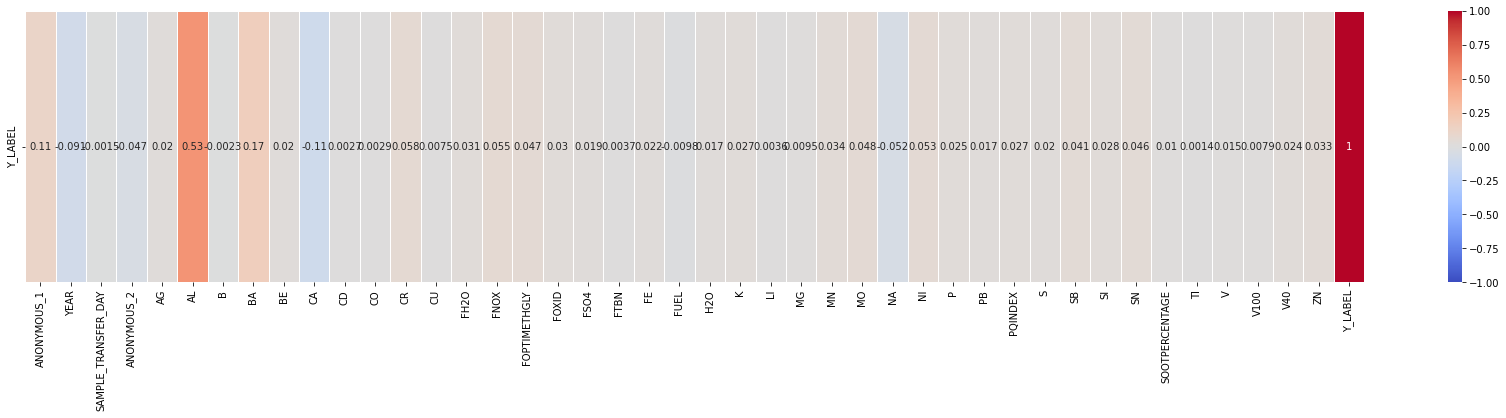

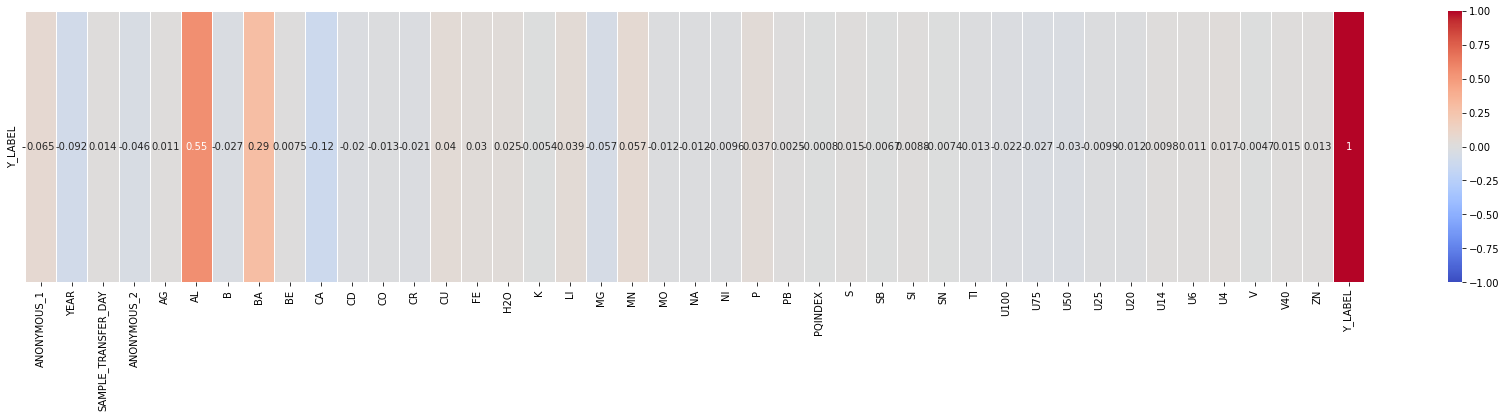

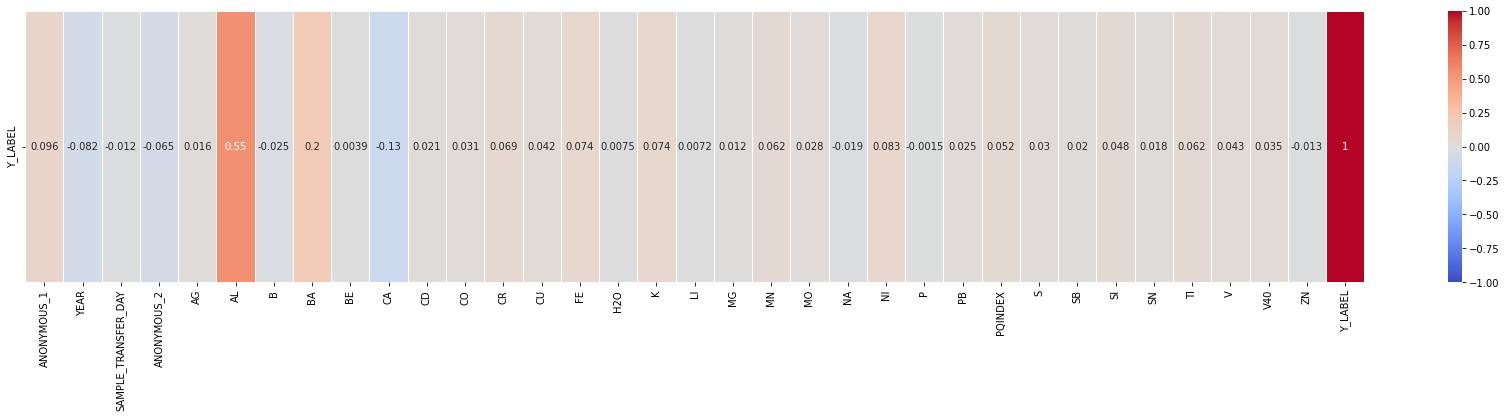

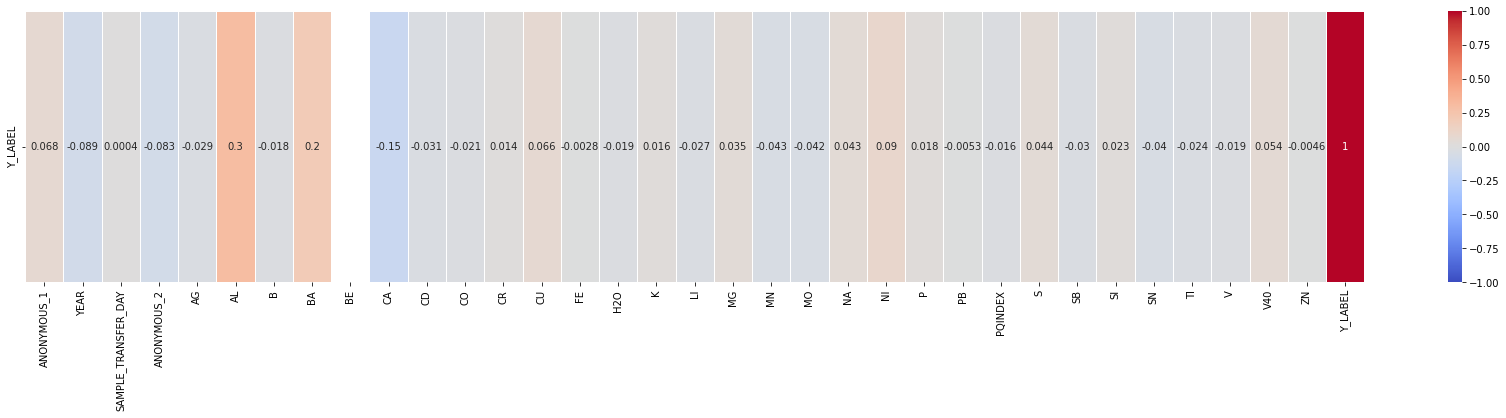

In [2101]:
for i in train_list:
    fig = plt.figure(figsize=(30, 5))
    sns.heatmap(i.loc[:,:].corr()[["Y_LABEL"]].T, annot=True, linewidth=1, cmap="coolwarm", vmin=-1, vmax=1)

In [2102]:
for i in train_list:
    df_corr = pd.DataFrame(i.corr()["Y_LABEL"].sort_values(ascending=False))
    print(df_corr)
    print("="*50)

                      Y_LABEL
Y_LABEL              1.000000
AL                   0.527115
BA                   0.165290
ANONYMOUS_1          0.109950
CR                   0.058491
FNOX                 0.055111
NI                   0.052885
MO                   0.047680
FOPTIMETHGLY         0.047399
SN                   0.045864
SB                   0.040558
MN                   0.034396
ZN                   0.032980
FH2O                 0.031025
FOXID                0.029537
SI                   0.028073
PQINDEX              0.027366
K                    0.027093
P                    0.024961
V40                  0.024496
FE                   0.021825
S                    0.020355
AG                   0.020270
BE                   0.019857
FSO4                 0.019153
PB                   0.017147
H2O                  0.016556
V                    0.014919
SOOTPERCENTAGE       0.010065
MG                   0.009531
V100                 0.007902
CU                   0.007482
FTBN      

In [2103]:
# 상관관계가 낮아서 제낄 칼럼 확인
for i, k in zip(train_list, test_list):
    cutline = CFG["corr_cut"]
    df_corr = pd.DataFrame(i.corr()["Y_LABEL"].sort_values(ascending=False))
    df_corr1 = df_corr[(df_corr["Y_LABEL"] < cutline) & (df_corr["Y_LABEL"] > (cutline*-1))]
    print(f"상관계수 커트라인 : {cutline}, 드랍 칼럼 개수 : {len(df_corr1.index)}")
#     df_corr1.sort_values
    drop_columns = df_corr1.index.tolist()
    print(drop_columns)
    print(f"train 드랍하기 전 칼럼 갯수 : {len(i.columns)}")
    for col in drop_columns:
        if col in i.columns:
            i.drop(columns = col, axis = 1, inplace = True)
        else:
            pass
    print(f"train 드랍후 칼럼 갯수 : {len(i.columns)}")
    
    print(f"test 드랍하기 전 칼럼 갯수 : {len(k.columns)}")
    for col in drop_columns:
        if col in k.columns:
            k.drop(columns = col, axis = 1, inplace = True)
        else:
            pass
    print(f"test 드랍후 칼럼 갯수 : {len(k.columns)}")
    

상관계수 커트라인 : 0.004, 드랍 칼럼 개수 : 7
['FTBN', 'LI', 'CO', 'CD', 'TI', 'SAMPLE_TRANSFER_DAY', 'B']
train 드랍하기 전 칼럼 갯수 : 46
train 드랍후 칼럼 갯수 : 39
test 드랍하기 전 칼럼 갯수 : 20
test 드랍후 칼럼 갯수 : 18
상관계수 커트라인 : 0.004, 드랍 칼럼 개수 : 2
['PB', 'PQINDEX']
train 드랍하기 전 칼럼 갯수 : 45
train 드랍후 칼럼 갯수 : 43
test 드랍하기 전 칼럼 갯수 : 20
test 드랍후 칼럼 갯수 : 19
상관계수 커트라인 : 0.004, 드랍 칼럼 개수 : 2
['BE', 'P']
train 드랍하기 전 칼럼 갯수 : 37
train 드랍후 칼럼 갯수 : 35
test 드랍하기 전 칼럼 갯수 : 20
test 드랍후 칼럼 갯수 : 20
상관계수 커트라인 : 0.004, 드랍 칼럼 개수 : 2
['SAMPLE_TRANSFER_DAY', 'FE']
train 드랍하기 전 칼럼 갯수 : 37
train 드랍후 칼럼 갯수 : 35
test 드랍하기 전 칼럼 갯수 : 20
test 드랍후 칼럼 갯수 : 19


In [2104]:
test_c1.head(10)

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,V,V40,ZN,order
0,TEST_0000,COMPONENT1,-0.234189,2016,-0.602983,-0.150893,-1.061644,-0.832286,-0.697254,-0.05162,-0.667301,-1.394988,-0.323440,-0.163942,-0.155942,-0.849812,-0.394693,0
11,TEST_0011,COMPONENT1,-0.365942,2016,-0.602983,-0.150893,0.507357,0.000259,0.394780,-0.05162,-0.667301,1.162707,-0.323440,0.368492,-0.155942,1.722398,0.152158,11
12,TEST_0012,COMPONENT1,-0.098317,2013,-0.602983,-0.150893,-0.071715,-0.463879,-0.493579,-0.05162,-0.667301,0.455973,-0.323440,1.705617,-0.155942,1.144121,-0.941544,12
18,TEST_0018,COMPONENT1,-0.064667,2021,1.082505,-0.150893,-0.071715,-0.463879,0.712380,-0.05162,-0.667301,-1.394988,-0.323440,-1.025253,-0.155942,-1.153183,-0.467982,18
20,TEST_0020,COMPONENT1,-0.366803,2013,-0.602983,-0.150893,1.497286,1.057101,1.548976,-0.05162,-0.667301,1.079722,-0.323440,-0.040300,-0.155942,0.682360,-0.000058,20
24,TEST_0024,COMPONENT1,-0.304218,2008,-0.602983,-0.150893,0.507357,0.165917,-0.234081,-0.05162,0.889173,-1.051729,-0.323440,2.148652,6.285777,-0.387565,0.146521,24
30,TEST_0030,COMPONENT1,-0.665581,2013,1.862719,-0.150893,-1.061644,-1.462081,-1.220637,-0.05162,-0.667301,1.236207,-0.323440,-2.010206,-0.155942,-0.057914,-0.073347,30
33,TEST_0033,COMPONENT1,0.285484,2014,-0.602983,-0.150893,1.717438,-0.202490,1.355690,-0.05162,0.889173,0.580429,-0.323440,0.944653,-0.155942,1.150713,-0.541272,33
36,TEST_0036,COMPONENT1,-1.079581,2007,1.038777,-0.150893,1.497286,2.074038,1.275858,-0.05162,1.799652,-0.053913,2.304535,1.353446,-0.155942,-0.952509,0.135245,36
37,TEST_0037,COMPONENT1,1.029123,2016,-0.602983,-0.150893,-1.061644,-0.832286,-0.315434,-0.05162,0.889173,0.467626,-0.323440,0.685577,-0.155942,0.251060,-0.067710,37


In [2105]:
# drop_columns = df_corr1.index.tolist()
# drop_columns

In [2106]:
# print(f"드랍하기 전 칼럼 갯수 : {len(train.columns)}")
# for col in drop_columns:
#     if col in train.columns:
#         train.drop(columns = col, axis = 1, inplace = True)
#     else:
#         pass
# print(f"드랍후 칼럼 갯수 : {len(train.columns)}")

In [2107]:
# print(f"드랍하기 전 칼럼 갯수 : {len(test.columns)}")
# for col in drop_columns:
#     if col in test.columns:
#         test.drop(columns = col, axis = 1, inplace = True)
#     else:
#         pass
# print(f"드랍후 칼럼 갯수 : {len(test.columns)}")

In [2108]:
# 상관관계 낮은 칼럼 드랍
# train.drop(df_corr1.index.tolist(), axis = 1, inplace=True)
# train.columns

## (6) 수치형 데이터 이상치 처리

In [2109]:
# not_number_features = ['ID','COMPONENT_ARBITRARY', 'SAMPLE_TRANSFER_DAY','YEAR', "Y_LABEL"]
# train.drop(columns = "ID", axis = 1, inplace = True)
# test.drop(columns = "ID", axis = 1, inplace = True)

In [2110]:
#이상치 인덱스 확인 함수
# def get_outlier(df=None, col=None, weight=1.5):
#     target = df[col]
#     quantile_25 = np.quantile(target, 0.25)
#     quantile_75 = np.quantile(target, 0.75)
#     iqr = quantile_75 - quantile_25
#     iqr_weight = iqr * weight
#     lowest_val = quantile_25 - iqr_weight
#     highest_val = quantile_75 + iqr_weight
#     outlier_index = target[(target < lowest_val) | (target > highest_val)].index
#     return outlier_index

In [2111]:
# get_outlier(train, "CO")

In [2112]:
# 이상치칼럼 = []
# huddle = CFG["outlier_corr_cut"]  # 허들이상의 상관관계를 가진 칼럼에 대해서만 이상치 드랍
# print(huddle)

# for target1 in train.columns:
#     if target1 not in not_number_features and ((df_corr.loc[[target1]].values[0][0] >= huddle) or (df_corr.loc[[target1]].values[0][0] <= (huddle*-1))):
#         이상치칼럼.append(target1)
        
#         outlier_index = get_outlier(train, target1)
#         print(f"검토대상: {target1}, 상관관계: {df_corr.loc[[target1]].values[0][0]:.2f}, 드랍갯수: {len(outlier_index)}")
        
#         train.drop(index=outlier_index, inplace=True)

#     else:
#         pass
    
# print(f"이상치칼럼: {target1}, "드랍갯수": {len(outlier_index)})

In [2113]:
# if target1 in 이상치칼럼 :
#     print(target1)
#     outlier_index2 = get_outlier(test, target1)
#     print(f"드랍대상 아웃라이어 인덱스 갯수 : {len(outlier_index2)}")

#     test.drop(index=outlier_index, inplace=True)
# else:
#     pass

In [2114]:
# train.head(2)

#### 연도 칼럼을 원핫으로 유지할 필요가 있을까?

In [2115]:
# target = "YEAR"
# 정상 = train[train["Y_LABEL"] == 0][target]
# 이상= train[train["Y_LABEL"] == 1][target]
# plt.figure(figsize = (12,6))
# sns.distplot(정상,bins = 15, color="red")
# sns.distplot(이상,bins = 15, color="green")

In [2116]:
# print(train[train["Y_LABEL"]==0]["COMPONENT_ARBITRARY"].value_counts())
# print(train[train["Y_LABEL"]==1]["COMPONENT_ARBITRARY"].value_counts())

In [2117]:
# additonal_drop_cols = ["YEAR"]
# train = train.drop(additonal_drop_cols, axis=1)
# test = test.drop(additonal_drop_cols, axis=1)
# print(train.columns)
# print(test.columns)

## (7) 인코딩

In [2118]:
def onehot_encode(df, target_cols):
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first', sparse=False),target_cols)], remainder='passthrough')
    df = ct.fit_transform(df)
    df = pd.DataFrame(df)
    new_name = ct.get_feature_names()
    df.columns = new_name
    return df

In [2119]:
# for i, k in zip(train_list, test_list):
#     print(i.columns)
#     print(k.head(10))
#     print("-"*50)

In [2120]:
import pickle

In [2121]:
num = 1
for i, k in zip(train_list, test_list):
    i.drop(columns = "ID", axis = 1, inplace = True)
    k.drop(columns = "ID", axis = 1, inplace = True)
    i = onehot_encode(i, [0, 2])
    k = onehot_encode(k, [0, 2])
#     print(k.head(10))
#     print("-"*50)

    for a in range(0, len(i.columns)):
        i.iloc[:,a] = pd.to_numeric(i.iloc[:,a], errors='ignore')
    
    for b in range(0, len(k.columns)):
        k.iloc[:,b] = pd.to_numeric(k.iloc[:,b], errors='ignore')
    
#     print(i.info())
#     print(k.head(10))
#     print("="*50)
    
    all_X = i.drop(['Y_LABEL'], axis = 1)
    all_y = i['Y_LABEL']
    
    
    
    train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)
    
#     temp_list = [train_X, val_X, train_y, val_y]
    
#     train_X.info()
    
  
    
    #저장하기
    with open(f"./data/{file_version}_{num}_train_X", 'wb') as pickle_filename:
        pickle.dump(train_X, pickle_filename)

    with open(f"./data/{file_version}_{num}_train_y", 'wb') as pickle_filename:
        pickle.dump(train_y, pickle_filename)

    with open(f"./data/{file_version}_{num}_val_X", 'wb') as pickle_filename:
        pickle.dump(val_X, pickle_filename)

    with open(f"./data/{file_version}_{num}_val_y", 'wb') as pickle_filename:
        pickle.dump(val_y, pickle_filename)

    with open(f"./data/{file_version}_{num}_test", 'wb') as pickle_filename:
        pickle.dump(k, pickle_filename)
    
    num += 1

print("작업 완료")

작업 완료
